<a href="https://colab.research.google.com/github/ljcotica/DataScience/blob/main/DBT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **dbt(Data Build Tool) Tutorial**

## **1. Introdução**
Este artigo é voltado para estudantes, analistas, engenheiros ou qualquer pessoa da área de dados e está curioso sobre o que é dbt e como usá-lo.

## **2. Dbt, o T em ELT**
Em um pipeline ELT, os dados brutos são carregados (EL) no data warehouse. Em seguida, os dados brutos são transformados em tabelas utilizáveis, usando consultas SQL executadas no data warehouse.

O dbt fornece uma maneira fácil de criar, transformar e validar os dados em um data warehouse. ***dbt*** faz o T em processos ELT (Extrair, Carregar, Transformar).

No dbt, trabalhamos com ***modelos***, que é um ***arquivo sql com uma instrução select***. Esses modelos podem depender de outros modelos, ter testes definidos neles e podem ser criados como tabelas ou visualizações. Os nomes dos modelos criados pelo dbt são seus nomes de arquivo.

Por exemplo: O arquivo ***dim_customers.sql*** representa o modelo denominado ***dim_customers***. Este modelo depende dos modelos ***stg_eltool_customers*** e ***stg_eltool_state***. O modelo ***dim_customers*** pode então ser referenciado em outras definições de modelo.

In [ ]:
with customers as (
    select *
    from {{ ref('stg_eltool_customers') }}
),
state as (
    select *
    from {{ ref('stg_eltool_state') }}
)
select c.customer_id,
    c.zipcode,
    c.city,
    c.state_code,
    s.state_name,
    c.datetime_created,
    c.datetime_updated,
    c.dbt_valid_from::TIMESTAMP as valid_from,
    CASE
        WHEN c.dbt_valid_to IS NULL THEN '9999-12-31'::TIMESTAMP
        ELSE c.dbt_valid_to::TIMESTAMP
    END as valid_to
from customers c
    join state s on c.state_code = s.state_code

Podemos ***definir testes a serem executados em dados processados*** usando dbt. Dbt nos permite criar 2 tipos de testes, eles são:

1.  ***Testes genéricos***: testes *unique, not_null, accept_values* e *relacionamentos por coluna* definidos em arquivos YAML. Por exemplo. 
2.  ***Testes sob medida*** (também conhecidos como únicos): scripts Sql criados na pasta de testes. Eles podem ser qualquer consulta. Eles são bem-sucedidos se os scripts sql não retornam nenhuma linha, senão malsucedidos.
Por exemplo. O arquivo ***core.yml*** contém testes para os modelos ***dim_customers*** e ***fct_orders***.

In [ ]:
version: 2

models:
  - name: dim_customers
    columns:
      - name: customer_id
        tests:
          - not_null # checks if customer_id column in dim_customers is not null
  - name: fct_orders

## **3. Projeto**
Somos solicitados pela equipe de marketing a criar uma tabela desnormalizada ***customer_orders***, com informações sobre todos os pedidos feitos pelos clientes. Vamos supor que os dados dos ***clientes e pedidos*** sejam carregados no armazém por um processo.

O processo usado para trazer esses dados para nosso data warehouse é a parte EL. Isso pode ser feito usando um serviço de fornecedor como Fivetran, Stitch ou serviços de código aberto como Singer, Airbyte ou usando um serviço personalizado.

Vamos ver como nossos dados são transformados na tabela final desnormalizada.

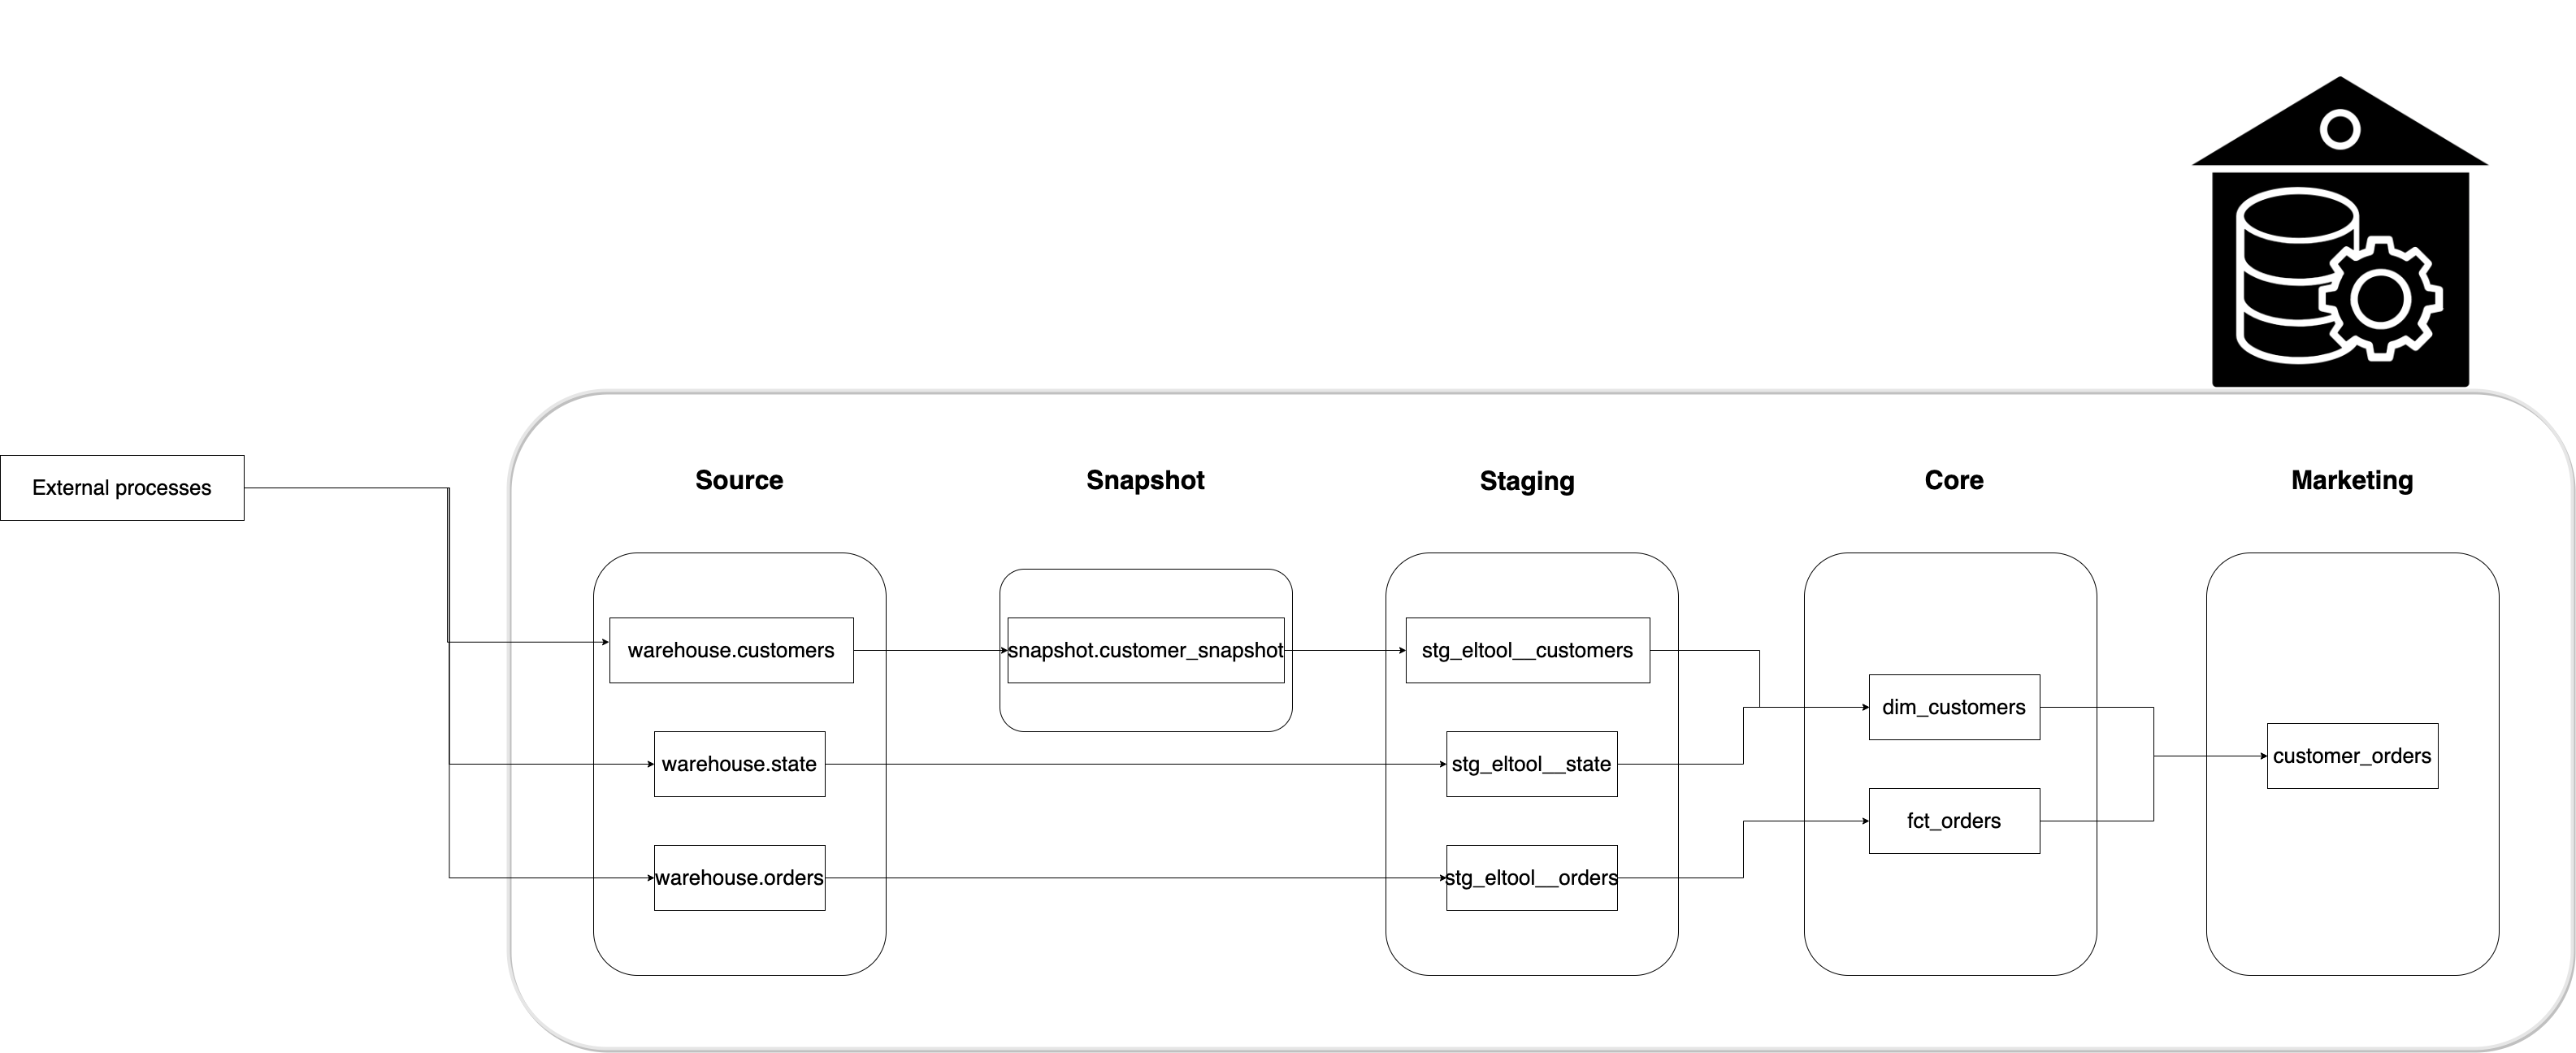

Seguiremos as melhores práticas de data warehouse, como tabelas de preparação, testes, uso de dimensões de alteração lenta tipo 2 e convenções de nomenclatura.

### **3.1. Pré-requisitos**
Para codificar, você precisará:

*  [Docker](https://https://docs.docker.com/get-docker/) e [Docker compose](https://docs.docker.com/compose/install/)
*  [dbt](https://docs.getdbt.com/dbt-cli/installation/)
*  [pgcli](https://www.pgcli.com/install)
*  [git](https://git-scm.com/book/en/v2/Getting-Started-Installing-Git)

Clone o repositório git e inicie o contêiner docker do data warehouse

In [ ]:
git clone https://github.com/josephmachado/simple_dbt_project.git
export DBT_PROFILES_DIR=$(pwd)
docker compose up -d
cd simple_dbt_project

Por padrão, o ***dbt*** procurará conexões de warehouse no arquivo ***~/.dbt/profiles.yml***. A variável de ambiente ***DBT_PROFILES_DIR*** diz ao dbt para procurar o arquivo ***profiles.yml*** no diretório de trabalho atual.

Você também pode criar um projeto dbt usando ***dbt init***. Isso fornecerá a você um projeto de amostra, que você pode modificar.

Na pasta ***simple_dbt_project***, você verá as seguintes pastas.

.<br>
├── analysis<br>
├── data<br>
├── macros<br>
├── models<br>
│   ├── marts<br>
│   │   ├── core<br>
│   │   └── marketing<br>
│   └── staging<br>
├── snapshots<br>
└── tests<br>

1. ***analysis***: Todos os arquivos ***.sql*** encontrados nesta pasta serão compilados para sql bruto quando você executar ***dbt compile***. Eles não serão executados pelo dbt, mas podem ser copiados em qualquer ferramenta de sua escolha.
2. ***data***: podemos armazenar dados brutos que desejamos carregar em nosso data warehouse. Isso normalmente é usado para armazenar pequenos dados de mapeamento.
3. ***macros***: Dbt permite aos usuários criar macros, que são funções baseadas em sql. Essas macros podem ser reutilizadas em nosso projeto.

Examinaremos as pastas ***models***, ***snapshots*** e ***tests*** nas seções abaixo.

## **3.2. Configurações e conexões**
Vamos definir as conexões do warehouse e as configurações do projeto.

### **3.2.1. profiles.yml**
Dbt requer um arquivo ***profiles.yml*** para conter detalhes de conexão do data warehouse. Definimos os detalhes da conexão do warehouse em ***simple_dbt_project/profiles.yml***.

A variável ***target*** define o ambiente. O padrão é dev. Podemos ter vários destinos, que podem ser especificados ao executar comandos ***dbt***.

O perfil é ***sde_dbt_tutorial***. O arquivo ***profiles.yml*** pode conter vários perfis para quando você tem mais de um projeto dbt.

### ***3.2.2. dbt_project.yml***
Neste arquivo, você pode definir o perfil a ser usado e os caminhos para diferentes tipos de arquivos (consulte * -paths).

A materialização é uma variável que controla como o dbt cria um modelo. Por padrão, todo modelo será uma visualização. Isso pode ser substituído em ***dbt_profiles.yml***. Definimos os modelos em ***models/marts/core/*** para se materializarem como tabelas.

In [ ]:
# Configuring models
models:
    sde_dbt_tutorial:
        # Applies to all files under models/marts/core/
        marts:
            core:
                materialized: table

## **3.3 Fluxo de dados**
Veremos como a tabela ***customer_orders*** é criada a partir das tabelas de origem. Essas transformações seguem as práticas recomendadas de warehouse e dbt.

### **3.3.1. Fonte**
As tabelas de origem referem-se às tabelas carregadas no warehouse por um processo EL. Como o dbt não os criou, temos que defini-los. Esta definição permite consultar as tabelas de origem usando a função de origem. Por ex. ***{{source ('warehouse', 'orders')}}*** refere-se à tabela ***warehouse.orders***. Também podemos definir testes para garantir que os dados de origem estejam limpos.

* Definição da fonte: ***sde_dbt_tutorial/models/staging/src_eltool.yml***

In [ ]:
version: 2

sources:
  - name: warehouse
    description: Data from application database, brought in by an EL process.
    tables:
      - name: customers
        columns:
        - name: customer_id
          tests:
            - not_null

      - name: orders
        columns:
        - name: order_id
          tests:
            - not_null
            - unique
        - name: cust_id
          tests:
            - relationships:
                to: source('warehouse', 'customers')
                field: customer_id
      
      - name: state

* Definições de teste: ***sde_dbt_tutorial/models/staging/src_eltool.yml***

In [ ]:
version: 2

sources:
  - name: warehouse
    description: Data from application database, brought in by an EL process.
    tables:
      - name: customers
        columns:
        - name: customer_id
          tests:
            - not_null

      - name: orders
        columns:
        - name: order_id
          tests:
            - not_null
            - unique
        - name: cust_id
          tests:
            - relationships:
                to: source('warehouse', 'customers')
                field: customer_id
      
      - name: state

### ***3.3.2. Snapshots***
Os atributos de uma entidade comercial mudam com o tempo. Essas mudanças devem ser capturadas em nosso data warehouse. Por exemplo. um usuário pode mudar para um novo endereço. Isso é chamado de dimensões de alteração lenta, na modelagem de data warehouse.

O Dbt nos permite criar facilmente essas tabelas de dimensão de alteração lenta (tipo 2) usando o recurso de snapchot. Ao criar um snapchot, precisamos definir o banco de dados, esquema, estratégia e colunas para identificar atualizações de linha.

In [ ]:
dbt snapshot

O Dbt cria uma tabela de snapchot na primeira execução e, em execuções consecutivas, verifica os valores alterados e atualiza as linhas mais antigas. Simulamos isso como mostrado abaixo.

In [ ]:
pgcli -h localhost -U dbt -p 5432 -d dbt
# password1234

In [ ]:
COPY warehouse.customers(customer_id, zipcode, city, state_code, datetime_created, datetime_updated)
FROM '/input_data/customer_new.csv' DELIMITER ',' CSV HEADER;

Execute o comando snapshot novamente.

In [ ]:
dbt snapshot

Dados não tratados

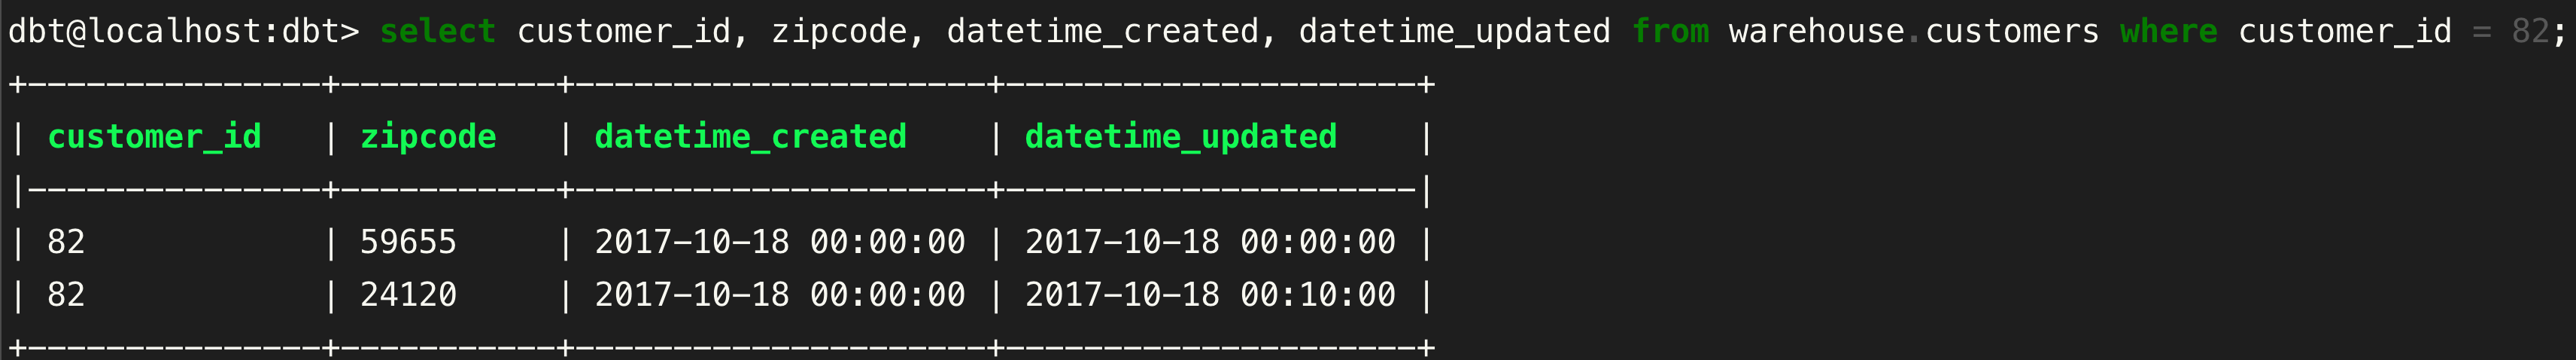

Tabela de snapshot

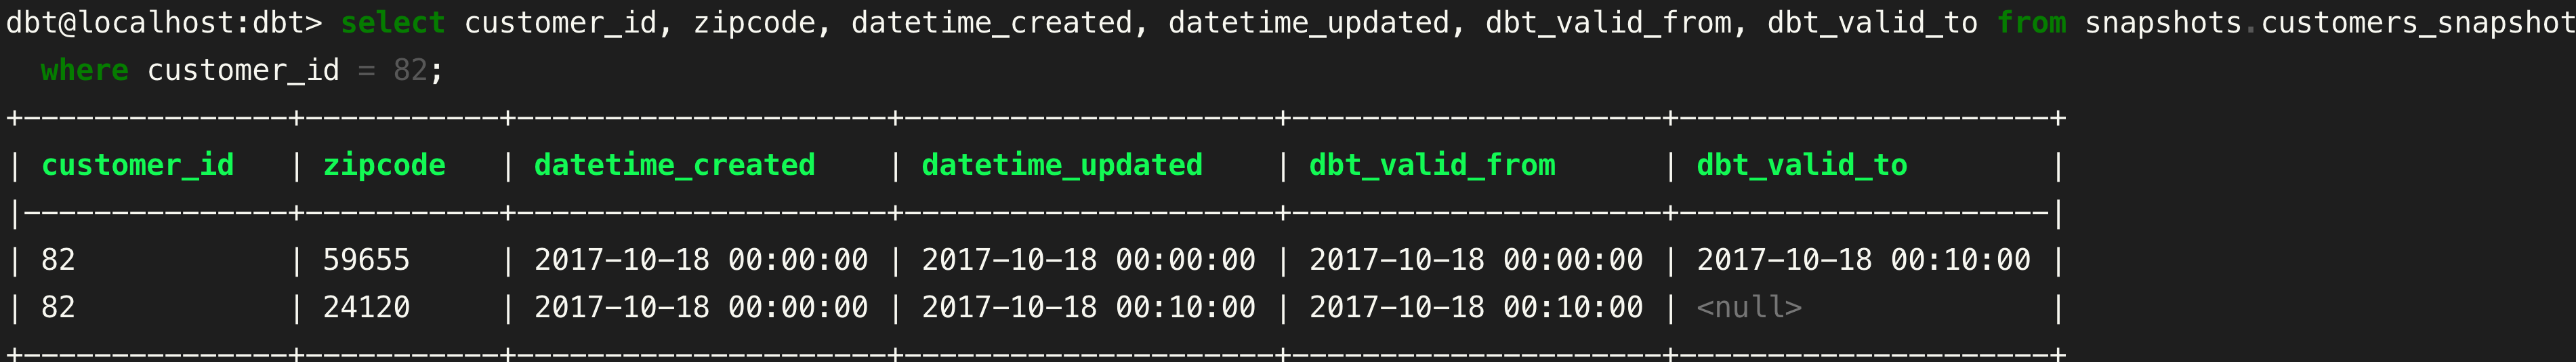

A linha com o zicode 59655 teve sua coluna ***dbt_valid_to*** atualizada. As colunas dbt ***from*** e ***to*** representam o intervalo de tempo em que os dados nessa linha são representativos do cliente 82.

* Definição do modelo: ***sde_dbt_tutorial/snapshots/customers.sql***

In [ ]:
{% snapshot customers_snapshot %}

{{
    config(
      target_database='dbt',
      target_schema='snapshots',
      unique_key='customer_id',

      strategy='timestamp',
      updated_at='datetime_updated',
    )
}}

select * from {{ source('warehouse', 'customers') }}

{% endsnapshot %}

### **3.3.3. Staging**
A staging area é onde os **dados brutos são convertidos em tipos de dados corretos, com nomes de coluna consistentes e preparados para serem transformados em modelos usados pelos usuários finais**.

Você deve ter notado o ***eltool*** nos nomes dos modelos de teste. Se usarmos Fivetran para dados EL, nossos modelos se chamarão ***stg_fivetran__orders*** e o arquivo YAML será ***stg_fivetran.yml***.

Em ***stg_eltool__customers.sql***, usamos a função ***ref*** em vez da função ***source*** porque este modelo é derivado do modelo ***snapshot***. Em dbt, podemos usar a função ref para nos referir a quaisquer modelos criados por dbt.



* Definições de teste: ***sde_dbt_tutorial/models/staging/stg_eltool.yml***

In [ ]:
version: 2

models:
  - name: stg_eltool__customers
    columns:
      - name: customer_id
        tests:
          - not_null
  - name: stg_eltool__orders
  - name: stg_eltool__state

* Definições de modelo: ***sde_dbt_tutorial/models/staging/stg_eltool__customers.sql***

In [ ]:
with source as (
    select *
    from {{ ref('customers_snapshot') }}
), renamed as (
    select customer_id,
        zipcode,
        city,
        state_code,
        datetime_created::TIMESTAMP AS datetime_created,
        datetime_updated::TIMESTAMP AS datetime_updated,
        dbt_valid_from,
        dbt_valid_to
    from source
)
select *
from renamed

* Definições de modelo: ***stg_eltool__orders.sql***

In [ ]:
with source as (
    select *
    from {{ source('warehouse', 'orders') }}
),
renamed as (
    select order_id,
        cust_id AS customer_id,
        order_status,
        order_purchase_timestamp::TIMESTAMP,
        order_approved_at::TIMESTAMP,
        order_delivered_carrier_date::TIMESTAMP,
        order_delivered_customer_date::TIMESTAMP,
        order_estimated_delivery_date::TIMESTAMP
        from source
)
select *
from renamed

Definições de modelo: ***stg_eltool__state.sql***

In [ ]:
with source as (
    select *
    from {{ source('warehouse', 'state') }}
),
renamed as (
    select state_identifier::INT AS state_id,
        state_code::VARCHAR(2) AS state_code,
        st_name::VARCHAR(30) AS state_name
    from source
)
select *
from renamed

### **3.3.4. Marts**
Os marts consistem em tabelas centrais para usuários finais e tabelas específicas de setores de negócios. Em nosso exemplo, temos uma pasta específica do departamento de marketing para definir o modelo solicitado pelo marketing.

* **3.3.4.1. Core**

O core define os modelos de fato e dimensão a serem usados pelos usuários finais. Os modelos de fatos e dimensões materializam-se em tabelas, para atuação no uso frequente. Os modelos de fato e dimensão são baseados no [modelo dimensional de kimball](https://www.kimballgroup.com/2003/01/fact-tables-and-dimension-tables/).

* Definições de teste: ***sde_dbt_tutorial/models/marts/core/core.yml***

In [ ]:
version: 2

models:
  - name: dim_customers
    columns:
      - name: customer_id
        tests:
          - not_null
  - name: fct_orders

* Definições de modelo dimensão: ***sde_dbt_tutorial/models/staging/dim_customers.sql***

In [ ]:
with customers as (
    select *
    from {{ ref('stg_eltool__customers') }}
),
state as (
    select *
    from {{ ref('stg_eltool__state') }}
)
select c.customer_id,
    c.zipcode,
    c.city,
    c.state_code,
    s.state_name,
    c.datetime_created,
    c.datetime_updated,
    c.dbt_valid_from::TIMESTAMP as valid_from,
    CASE
        WHEN c.dbt_valid_to IS NULL THEN '9999-12-31'::TIMESTAMP
        ELSE c.dbt_valid_to::TIMESTAMP
    END as valid_to
from customers c
    join state s on c.state_code = s.state_code

* Definições de modelo fato: ***fct_orders.sql***

In [ ]:
with orders as (
    select *
    from {{ ref('stg_eltool__orders') }}
)
select * from orders

Dbt oferece quatro testes genéricos, unique, not_null, accept_values e relationships. Podemos criar testes únicos (também conhecidos como personalizados) na pasta ***Tests***. Vamos criar um script de teste sql que verifica se alguma das linhas do cliente foi duplicada ou perdida. Se a consulta retornar um ou mais registros, os testes falharão. A compreensão desse script é deixada como um exercício para o leitor.

* Teste Único: ***sde_dbt_tutorial/tests/assert_customer_dimension_has_no_row_loss.sql***

In [ ]:
-- dim_customers must have the same number of rows as its staging counterpart
-- Therefore return records where this isn't true to make the test fail
select *
from (
        select dim_cust.customer_id
        from {{ ref('dim_customers') }} dim_cust
            left join {{ ref('stg_eltool__customers') }} stg_cust on dim_cust.customer_id = stg_cust.customer_id
        where stg_cust.customer_id is null
        UNION ALL
        select stg_cust.customer_id
        from {{ ref('stg_eltool__customers') }} stg_cust
            left join {{ ref('dim_customers') }} dim_cust on stg_cust.customer_id = dim_cust.customer_id
        where dim_cust.customer_id is null
    ) tmp

* **3.3.4.2. Marketing**

Nesta seção, definimos os modelos para usuários finais de marketing. Um projeto pode ter vários setores de negócios. Ter uma pasta por vertical de negócios fornece uma maneira fácil de organizar os modelos.

* Definições de teste: ***sde_dbt_tutorial/models/marts/marketing/marketing.yml***

In [ ]:
version: 2

models:
  - name: customer_orders
    columns:
      - name: customer_id
        tests:
          - not_null
      - name: order_id
        tests:
          - unique
      - name: order_status
        tests:
          - accepted_values:
              values: ['delivered', 'invoiced', 'shipped', 'processing', 'canceled', 'unavailable']

* Definições de modelo: ***sde_dbt_tutorial/models/marts/marketing/customer_orders.sql***

In [ ]:
with orders as (
    select *
    from {{ ref('fct_orders') }}
),
customers as (
    select *
    from {{ ref('dim_customers') }}
)
select o.order_id,
    o.customer_id,
    o.order_status,
    o.order_purchase_timestamp,
    o.order_approved_at,
    o.order_delivered_carrier_date,
    o.order_delivered_customer_date,
    o.order_estimated_delivery_date,
    c.zipcode as customer_zipcode,
    c.city as customer_city,
    c.state_code as customer_state_code,
    c.state_name as customer_state_name
from orders o
    join customers c on o.customer_id = c.customer_id
    and o.order_purchase_timestamp >= c.valid_from
    and o.order_purchase_timestamp <= c.valid_to

## **3.4. dbt run**
Temos as definições de modelo necessárias em vigor. Vamos criar os modelos.

In [ ]:
dbt snapshot
dbt run
...
Finished running 4 view models, 2 table models ...

O modelo ***stg_eltool__customers*** requer o modelo ***snapshots.customers_snapshot***. Mas os snapshots não são criados no ***dbt run***, portanto, executamos o ***dbt snapshot*** primeiro.

Nossos modelos de staging e marketing são como visões materializadas e os dois modelos principais são materializados como tabelas.

**O comando snapshot deve ser executado independentemente do comando run** para manter as tabelas de snapshot atualizadas. Se as tabelas de snapshot estiverem desatualizadas, os modelos estarão incorretos. Há monitoramento de atualização de snapshot em [dbt cloud UI](https://docs.getdbt.com/docs/dbt-cloud/using-dbt-cloud/cloud-snapshotting-source-freshness/#source-freshness-snapshot-frequency).

## **3.5. dbt test**
Com os modelos definidos, podemos executar testes neles. Observe que, ao contrário do teste padrão, esses testes são executados após o processamento dos dados. Você pode executar testes conforme mostrado abaixo.

In [ ]:
dbt test
...
Finished running 10 tests...

O comando acima executa todos os testes definidos no projeto. Você pode fazer login no data warehouse para ver os modelos.

In [ ]:
pgcli -h localhost -U dbt -p 5432 -d dbt
# password is password1234
select * from warehouse.customer_orders limit 3;
\q

## **3.6. dbt docs**
Um dos recursos mais poderosos do dbt é sua documentação. Para gerar documentação e disponibilizá-la, execute os seguintes comandos:

In [ ]:
dbt docs generate
dbt docs serve

Você pode visitar ***http://localhost:8080*** para ver a documentação. Navegue para ***customer_orders*** dentro do projeto ***sde_dbt_tutorial*** no painel esquerdo. Clique no ícone de visualização do gráfico de linhagem no lado inferior direito. O gráfico de linhagem mostra as dependências de um modelo. Você também pode ver os testes definidos, as descrições (definidas no arquivo YAML correspondente) e as instruções sql compiladas.

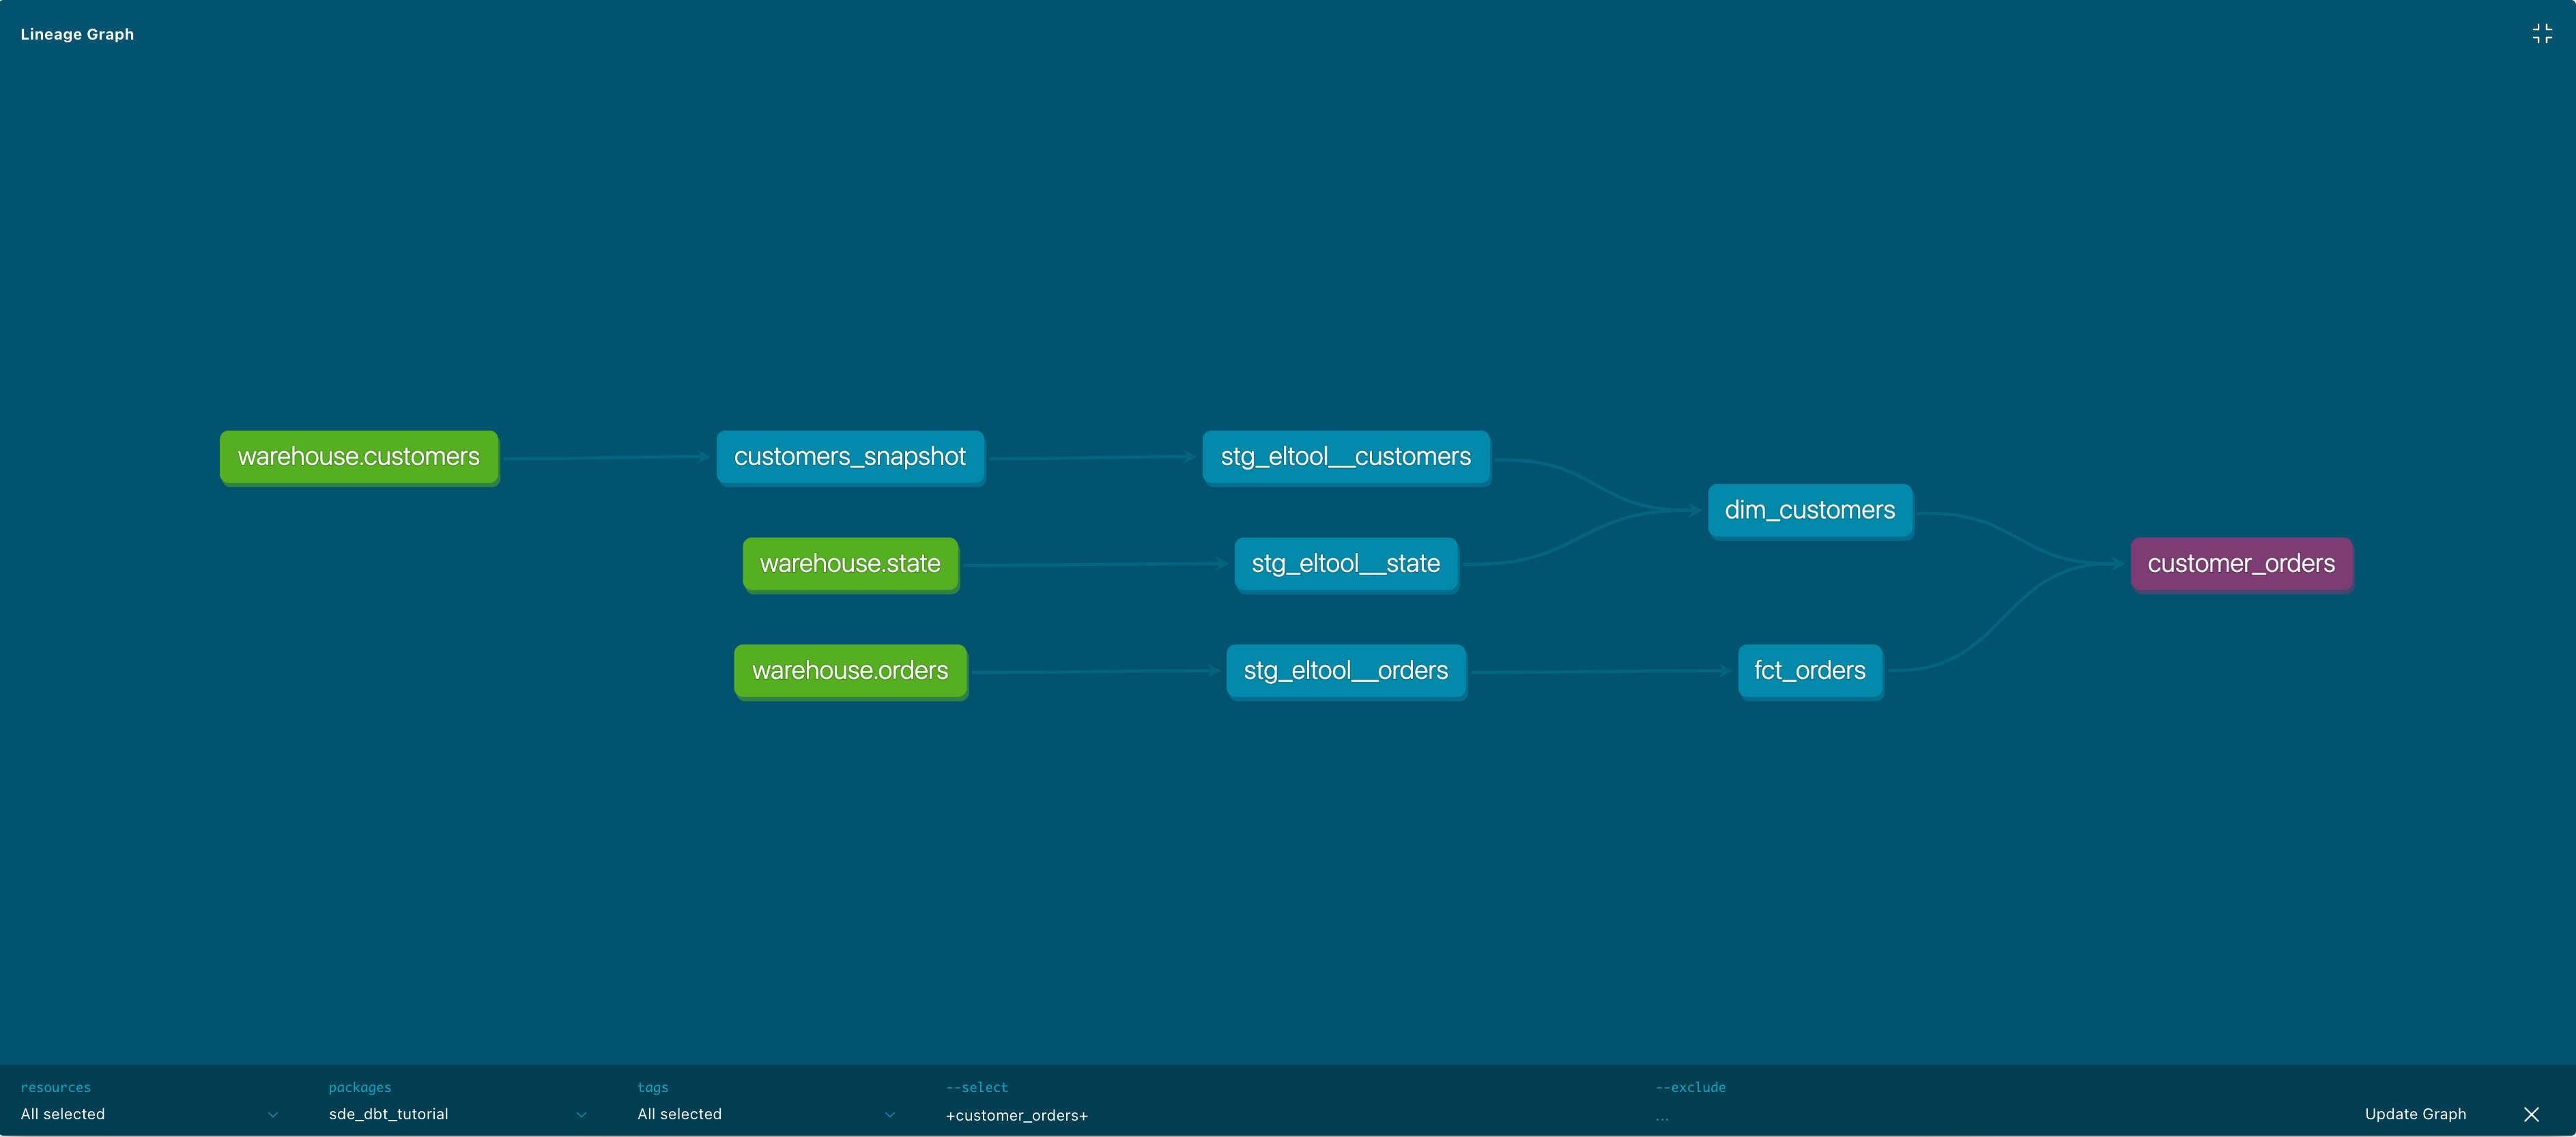

## **3.7. Agendamento**
Vimos como criar snapchots, modelos, executar testes e gerar documentação. Todos esses comandos são executados por meio do cli. O Dbt compila os modelos em consultas sql na pasta ***target*** (não faz parte do repo git) e os executa no data warehouse.

Para agendar execuções dbt, snapshots e testes, precisamos usar um agendador. O Dbt cloud é uma ótima opção para fazer um agendamento fácil. Os comandos dbt podem ser executados por outros programadores populares, como cron, Airflow, Dagster, etc.

# **4. Conclusão**
Dbt é uma ótima opção para construir seus pipelines ELT. Combinando as melhores práticas de data warehouse, testes, documentação, facilidade de uso, dados CI / CD, suporte da comunidade e uma grande oferta de nuvem, o dbt se configurou como uma ferramenta essencial para engenheiros de dados. Aprender e compreender o dbt também pode melhorar significativamente suas chances de conseguir um emprego de DE.

Para recapitular, nós examinamos

1. Estrutura do projeto Dbt
2. Configurando conexões
3. Gerando SCD2 (também conhecido como snapshots) com dbt
4. Gerando modelos seguindo as melhores práticas
5. Modelos de teste
6. Gerando e visualizando documentação

O dbt pode ajudá-lo a tornar seus pipelines ELT estáveis e divertidos de desenvolvimento. 

Tradução livre.
Fonte: https://www.startdataengineering.com/post/dbt-data-build-tool-tutorial/